# Solutions 1 - Examples in Julia

---

## Assignment 1

The function `eps()` return the smallest real number larger than 1.0. It can be called for each of the `AbstractFloat` types. 

Functions `realmin()` and `realmax()` return the largest and the smallest positive numbers representable in the given type.

In [1]:
?eps

search: eps @elapsed indexpids expanduser escape_string setprecision peakflops



```
eps(::Type{T}) where T<:AbstractFloat
eps()
```

Returns the *machine epsilon* of the floating point type `T` (`T = Float64` by default). This is defined as the gap between 1 and the next largest value representable by `T`, and is equivalent to `eps(one(T))`.

```jldoctest
julia> eps()
2.220446049250313e-16

julia> eps(Float32)
1.1920929f-7

julia> 1.0 + eps()
1.0000000000000002

julia> 1.0 + eps()/2
1.0
```

```
eps(x::AbstractFloat)
```

Returns the *unit in last place* (ulp) of `x`. This is the distance between consecutive representable floating point values at `x`. In most cases, if the distance on either side of `x` is different, then the larger of the two is taken, that is

```
eps(x) == max(x-prevfloat(x), nextfloat(x)-x)
```

The exceptions to this rule are the smallest and largest finite values (e.g. `nextfloat(-Inf)` and `prevfloat(Inf)` for [`Float64`](@ref)), which round to the smaller of the values.

The rationale for this behavior is that `eps` bounds the floating point rounding error. Under the default `RoundNearest` rounding mode, if $y$ is a real number and $x$ is the nearest floating point number to $y$, then

$$
|y-x| \leq \operatorname{eps}(x)/2.
$$

```jldoctest
julia> eps(1.0)
2.220446049250313e-16

julia> eps(prevfloat(2.0))
2.220446049250313e-16

julia> eps(2.0)
4.440892098500626e-16

julia> x = prevfloat(Inf)      # largest finite Float64
1.7976931348623157e308

julia> x + eps(x)/2            # rounds up
Inf

julia> x + prevfloat(eps(x)/2) # rounds down
1.7976931348623157e308
```

```
eps(::DateTime) -> Millisecond
eps(::Date) -> Day
eps(::Time) -> Nanosecond
```

Returns `Millisecond(1)` for `DateTime` values, `Day(1)` for `Date` values, and `Nanosecond(1)` for `Time` values.


In [2]:
?realmax

search: realmax realmin readdlm ReadOnlyMemoryError



```
realmax(T)
```

The highest finite value representable by the given floating-point DataType `T`.

```jldoctest
julia> realmax(Float16)
Float16(6.55e4)

julia> realmax(Float32)
3.4028235f38
```


In [3]:
subtypes(AbstractFloat)

4-element Array{Union{DataType, UnionAll},1}:
 BigFloat
 Float16 
 Float32 
 Float64 

In [4]:
# Default values are for Float64
eps(), realmax(), realmin()

(2.220446049250313e-16, 1.7976931348623157e308, 2.2250738585072014e-308)

In [5]:
T=Float32
eps(T), realmax(T), realmin(Float32)

(1.1920929f-7, 3.4028235f38, 1.1754944f-38)

In [6]:
T=BigFloat
eps(T), realmax(T), realmin(T), map(Int64,round(log10(1/eps(T))*log(10)/log(2)))

(1.727233711018888925077270372560079914223200072887256277004740694033718360632485e-77, 2.09857871646738769240435811688383907063809796547335262778664622571024044777575e+323228496, 2.382564904887951073216169781732674520415196125559239787955023752600945386104324e-323228497, 255)

We see that `BigFloat` has approximately 77 significant decimal digits (actually 256 bits) and very large exponents. This makes the format ideal for Greaffe's method. 

Precision of `BigFloat` can be increased, but exponents do not change.

In [7]:
precision(BigFloat)

256

In [8]:
setprecision(512)
eps(T), realmax(T)

(1.49166814624004134865819306309258676747529430692008137885430366664125567701402366098723497808008556067230232065116722029068254561904506053209723296591841694e-154, 2.09857871646738769240435811688383907063809796547335262778664622571024044777576820818355304081267655987295599577960564840596747121502665142009783113610500033e+323228496)

In [9]:
setprecision(256)

256

Here is the function for Graeffe's method. We also define small test polynomial with all real simple zeros.

In [10]:
using Polynomials
p=poly([1,2,3,4])

Poly(24 - 50*x + 35*x^2 - 10*x^3 + x^4)

In [11]:
roots(p)

4-element Array{Float64,1}:
 4.0
 3.0
 2.0
 1.0

In [12]:
function Graeffe{T}(p::Poly{T},steps::Int64)
    # map the polynomial to BigFloat
    pbig=Poly(map(BigFloat,coeffs(p)))
    px=Poly([zero(BigFloat),one(BigFloat)])
    n=degree(p)
    σ=map(BigFloat,2^steps)
    for k=1:steps
        peven=Poly(coeffs(pbig)[1:2:end])
        podd=Poly(coeffs(pbig)[2:2:end])
        pbig=peven^2-podd^2*px 
    end
    # @show p[end]
    y=Array{BigFloat}(n)
    # Normalize if p is not monic
    y[1]=-pbig[end-1]/pbig[end]
    for k=2:n
        y[k]=-pbig[end-k]/pbig[end-(k-1)]
    end
    # Extract the roots
    for k=1:n
        y[k]=exp(log(y[k])/σ)
    end
    # Return root in Float64
    map(Float64,y)
end

Graeffe (generic function with 1 method)

In [13]:
Graeffe(p,8)

4-element Array{Float64,1}:
 4.0
 3.0
 2.0
 1.0

Now the Wilkinson's polynomial:

In [14]:
ω=poly(collect(one(BigFloat):20))

Poly(2.432902008176640000000000000000000000000000000000000000000000000000000000000000e+18 - 8.752948036761600000000000000000000000000000000000000000000000000000000000000000e+18*x + 1.380375975364070400000000000000000000000000000000000000000000000000000000000000e+19*x^2 - 1.287093124515098880000000000000000000000000000000000000000000000000000000000000e+19*x^3 + 8.037811822645051776000000000000000000000000000000000000000000000000000000000000e+18*x^4 - 3.599979517947607200000000000000000000000000000000000000000000000000000000000000e+18*x^5 + 1.206647803780373360000000000000000000000000000000000000000000000000000000000000e+18*x^6 - 3.113336431613906400000000000000000000000000000000000000000000000000000000000000e+17*x^7 + 6.303081209929489600000000000000000000000000000000000000000000000000000000000000e+16*x^8 - 1.014229986551145000000000000000000000000000000000000000000000000000000000000000e+16*x^9 + 1.307535010540395000000000000000000000000000000000000000000000000000000000000000e+15*x^10 - 1.355851828995300000000000000000000000000000000000000000000000000000000000000000e+14*x^11 + 1.131027699538100000000000000000000000000000000000000000000000000000000000000000e+13*x^12 - 7.561111845000000000000000000000000000000000000000000000000000000000000000000000e+11*x^13 + 4.017177163000000000000000000000000000000000000000000000000000000000000000000000e+10*x^14 - 1.672280820000000000000000000000000000000000000000000000000000000000000000000000e+09*x^15 + 5.332794600000000000000000000000000000000000000000000000000000000000000000000000e+07*x^16 - 1.256850000000000000000000000000000000000000000000000000000000000000000000000000e+06*x^17 + 2.061500000000000000000000000000000000000000000000000000000000000000000000000000e+04*x^18 - 2.100000000000000000000000000000000000000000000000000000000000000000000000000000e+02*x^19 + 1.000000000000000000000000000000000000000000000000000000000000000000000000000000*x^20)

In [15]:
Graeffe(ω,8)

20-element Array{Float64,1}:
 20.0
 19.0
 18.0
 17.0
 16.0
 15.0
 14.0
 13.0
 12.0
 11.0
 10.0
  9.0
  8.0
  7.0
  6.0
  5.0
  4.0
  3.0
  2.0
  1.0

In [16]:
ans[2]

18.999999925187158

In [17]:
Graeffe(ω,16)

20-element Array{Float64,1}:
 20.0
 19.0
 18.0
 17.0
 16.0
 15.0
 14.0
 13.0
 12.0
 11.0
 10.0
  9.0
  8.0
  7.0
  6.0
  5.0
  4.0
  3.0
  2.0
  1.0

In [18]:
ans[2]

19.0

We now generate the Chebyshev polynomial $T_{50}(x)$ using the three term recurence.

In [19]:
n=50
T0=Poly([BigInt(1)])
T1=Poly([0,1])
Tx=Poly([0,1])
for i=3:n+1
    T=2*Tx*T1-T0
    T0=T1
    T1=T
end

In [20]:
T

Poly(-1 + 1250*x^2 - 260000*x^4 + 21528000*x^6 - 947232000*x^8 + 25638412800*x^10 - 466152960000*x^12 + 6034375680000*x^14 - 57930006528000*x^16 + 424820047872000*x^18 - 2432653747814400*x^20 + 11057517035520000*x^22 - 40383975260160000*x^24 + 119536566770073600*x^26 - 288405684905574400*x^28 + 568855350917201920*x^30 - 917508630511616000*x^32 + 1206989963132928000*x^34 - 1287455960675123200*x^36 + 1102487181118668800*x^38 - 746299014911098880*x^40 + 390051749953536000*x^42 - 151732604633088000*x^44 + 41341637204377600*x^46 - 7036874417766400*x^48 + 562949953421312*x^50)

In [21]:
using Gadfly

In [22]:
f(x)=T(x)

f (generic function with 1 method)

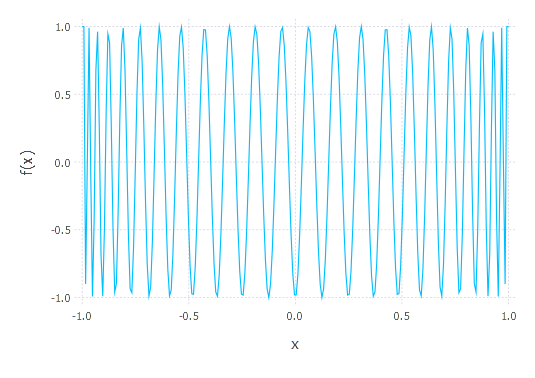

In [23]:
plot(f,-1,1)

In order to use Graeffe's method, we need to shift $T$ to the right by one, so that all roots also have simple moduli, that is, we compute $T(1-x)$:

In [24]:
Ts=T(Poly([BigFloat(1),-1]));

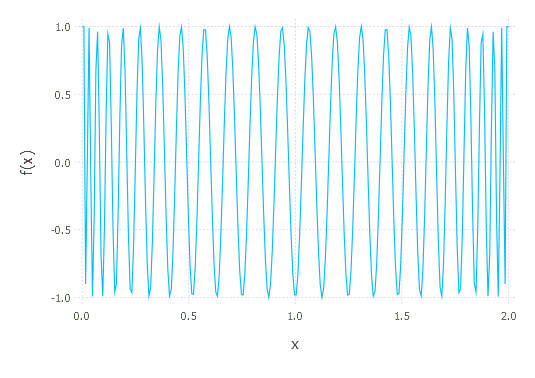

In [25]:
fs(x)=Ts(x)
plot(fs,0,2)

In [26]:
# Computed roots, 16 steps are fine
y=Graeffe(Ts,12)-1

50-element Array{Float64,1}:
  0.999507
  0.995562
  0.987688
  0.975917
  0.960294
  0.940881
  0.917755
  0.891007
  0.860742
  0.827081
  0.790155
  0.750111
  0.707107
  ⋮       
 -0.750111
 -0.790155
 -0.827081
 -0.860742
 -0.891007
 -0.917755
 -0.940881
 -0.960294
 -0.975917
 -0.987688
 -0.995562
 -0.999507

In [27]:
# Exact roots
z=map(Float64,[cos((2*k-1)*pi/(2*n)) for k=1:n])

50-element Array{Float64,1}:
  0.999507
  0.995562
  0.987688
  0.975917
  0.960294
  0.940881
  0.917755
  0.891007
  0.860742
  0.827081
  0.790155
  0.750111
  0.707107
  ⋮       
 -0.750111
 -0.790155
 -0.827081
 -0.860742
 -0.891007
 -0.917755
 -0.940881
 -0.960294
 -0.975917
 -0.987688
 -0.995562
 -0.999507

In [28]:
# Relative error
maximum(abs.(z-y)./z)

1.5019142646242862e-7

## Assignment 2

The key is that `/` works for block matrices, too. $A$ is overwritten and must therefore be copied at the beggining of the function, so that the original matrix is not overwritten.

In [29]:
function mylu{T}(A1::Array{T}) # Strang, page 100
    A=copy(A1)
    n,m=size(A)
    for k=1:n-1
        for rho=k+1:n
            A[rho,k]=A[rho,k]/A[k,k]
            for l=k+1:n
                A[rho,l]=A[rho,l]-A[rho,k]*A[k,l]
            end
        end
    end
    # We return L and U
    L=tril(A,-1)
    U=triu(A)
    # This is the only difference for the block case
    for i=1:maximum(size(L))
        L[i,i]=one(L[1,1])
    end
    L,U
end

mylu (generic function with 1 method)

In [30]:
A=rand(5,5)

5×5 Array{Float64,2}:
 0.90485    0.518455  0.124216  0.340404   0.374659
 0.718449   0.394841  0.556092  0.557313   0.585128
 0.0859509  0.142666  0.23926   0.942617   0.989565
 0.943001   0.777059  0.82037   0.0513722  0.883262
 0.0307782  0.418656  0.10496   0.118561   0.179521

In [31]:
L,U=mylu(A)

([1.0 0.0 … 0.0 0.0; 0.793998 1.0 … 0.0 0.0; … ; 1.04216 -14.082 … 1.0 0.0; 0.0340147 -23.8535 … 1.10858 1.0], [0.90485 0.518455 … 0.340404 0.374659; 0.0 -0.0168118 … 0.287032 0.28765; … ; 0.0 0.0 … -2.71381 -2.0303; 0.0 0.0 … 0.0 -0.870599])

In [32]:
L*U-A

5×5 Array{Float64,2}:
  0.0          0.0   0.0           0.0           0.0        
  0.0          0.0   0.0           0.0           0.0        
  0.0          0.0   4.44089e-16   2.22045e-16   0.0        
  0.0          0.0  -1.33227e-15   2.22045e-16  -6.66134e-16
 -3.46945e-18  0.0  -5.41234e-16  -1.30451e-15   4.44089e-16

In [33]:
L

5×5 Array{Float64,2}:
 1.0          0.0     0.0      0.0      0.0
 0.793998     1.0     0.0      0.0      0.0
 0.0949891   -5.5567  1.0      0.0      0.0
 1.04216    -14.082   2.57557  1.0      0.0
 0.0340147  -23.8535  3.97655  1.10858  1.0

In [34]:
U

5×5 Array{Float64,2}:
 0.90485   0.518455   0.124216   0.340404   0.374659
 0.0      -0.0168118  0.457465   0.287032   0.28765 
 0.0       0.0        2.76946    2.50524    2.55236 
 0.0       0.0        0.0       -2.71381   -2.0303  
 0.0       0.0        0.0        0.0       -0.870599

We now try block-matrices. First, a small example:

In [35]:
# Try k,l=32,16 i k,l=64,8
k,l=2,4
Ab=[rand(k,k) for i=1:l, j=1:l]

4×4 Array{Array{Float64,2},2}:
 [0.968207 0.837488; 0.303045 0.738065]   …  [0.0492459 0.626796; 0.776475 0.182453]
 [0.016934 0.188388; 0.827176 0.374268]      [0.339001 0.689614; 0.373021 0.260164] 
 [0.863194 0.250849; 0.76696 0.200206]       [0.781743 0.730395; 0.937431 0.864636] 
 [0.0450596 0.152504; 0.953843 0.342371]     [0.760746 0.667996; 0.0864025 0.202442]

In [36]:
Ab[1,1]

2×2 Array{Float64,2}:
 0.968207  0.837488
 0.303045  0.738065

In [37]:
L,U=mylu(Ab)

(Array{Float64,2}[[1.0 0.0; 0.0 1.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [-0.0967691 0.36505; 1.07875 -0.716968] [1.0 0.0; 0.0 1.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [1.2176 -1.04175; 1.09677 -0.973253] [-1.76436 3.55775; 0.265856 1.79931] [1.0 0.0; 0.0 1.0] [0.0 0.0; 0.0 0.0]; [-0.0281219 0.238537; 1.3026 -1.0142] [1.5714 -0.432457; -2.07916 4.02044] [-0.695189 1.44793; 1.1665 -0.245354] [1.0 0.0; 0.0 1.0]], Array{Float64,2}[[0.968207 0.837488; 0.303045 0.738065] [0.0785302 0.0492419; 0.974924 0.221585] [0.549681 0.681371; 0.613738 0.231713] [0.0492459 0.626796; 0.776475 0.182453]; [0.0 0.0; 0.0 0.0] [0.311105 0.605235; 0.623675 0.404025] [0.805388 0.841157; 0.070689 -0.183324] [0.060314 0.683664; 0.876606 -0.285177]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [1.52 2.4479; -0.0612092 0.333401] [-1.48166 2.37809; 0.0458078 0.686124]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] [-0.235129 0.104229; -0.849586 -0.466706]])

In [38]:
L[1,1]

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [39]:
# Residual
R=L*U-Ab

4×4 Array{Array{Float64,2},2}:
 [0.0 0.0; 0.0 0.0]                            …  [0.0 0.0; 0.0 0.0]                          
 [0.0 0.0; 0.0 0.0]                               [0.0 0.0; 0.0 0.0]                          
 [-2.22045e-16 -1.11022e-16; 0.0 1.11022e-16]     [-2.22045e-16 0.0; 0.0 0.0]                 
 [0.0 0.0; 1.11022e-16 0.0]                       [0.0 1.11022e-16; -2.22045e-16 -2.22045e-16]

In [40]:
norm(R) # This is not defined

LoadError: [91mMethodError: no method matching zero(::Type{Array{Float64,2}})[0m
Closest candidates are:
  zero([91m::Type{Base.LibGit2.GitHash}[39m) at libgit2\oid.jl:106
  zero([91m::Type{Base.Pkg.Resolve.VersionWeights.VWPreBuildItem}[39m) at pkg\resolve\versionweight.jl:82
  zero([91m::Type{Base.Pkg.Resolve.VersionWeights.VWPreBuild}[39m) at pkg\resolve\versionweight.jl:124
  ...[39m

In [41]:
vecnorm(R)

6.290172397143774e-16

We need a convenience function to unblock the block-matrix:

In [42]:
unblock(A) = mapreduce(identity, hcat, 
    [mapreduce(identity, vcat, A[:,i]) for i = 1:size(A,2)])

unblock (generic function with 1 method)

In [43]:
unblock(Ab)

8×8 Array{Float64,2}:
 0.968207   0.837488  0.0785302  0.0492419  …  0.681371  0.0492459  0.626796
 0.303045   0.738065  0.974924   0.221585      0.231713  0.776475   0.182453
 0.016934   0.188388  0.659401   0.68136       0.859808  0.339001   0.689614
 0.827176   0.374268  0.0093996  0.298276      0.385571  0.373021   0.260164
 0.863194   0.250849  0.749974   0.198689      0.899824  0.781743   0.730395
 0.76696    0.200206  0.342175   0.72622    …  0.748961  0.937431   0.864636
 0.0450596  0.152504  0.449504   0.827814      0.218173  0.760746   0.667996
 0.953843   0.342371  0.974137   0.205387      0.940285  0.0864025  0.202442

In [44]:
norm(unblock(L*U-Ab))

5.114550381991061e-16

We now compute timings and errors for bigger example:

In [45]:
# This is 512x512 matrix consisting of 16x16 blocks of dimension 32x32
k,l=32,16
Ab=[rand(k,k) for i=1:l, j=1:l]
# Unblocked version
A=unblock(Ab);

In [46]:
?lu

search: lu lufact lufact! flush ClusterManager values include include_string



```
lu(A, pivot=Val{true}) -> L, U, p
```

Compute the LU factorization of `A`, such that `A[p,:] = L*U`. By default, pivoting is used. This can be overridden by passing `Val{false}` for the second argument.

See also [`lufact`](@ref).

# Example

```jldoctest
julia> A = [4. 3.; 6. 3.]
2×2 Array{Float64,2}:
 4.0  3.0
 6.0  3.0

julia> L, U, p = lu(A)
([1.0 0.0; 0.666667 1.0], [6.0 3.0; 0.0 1.0], [2, 1])

julia> A[p, :] == L * U
true
```


In [48]:
# Built-in LAPACK function with pivoting 
@time L,U,p=lu(A);

  0.071069 seconds (24 allocations: 6.009 MiB, 16.95% gc time)


In [49]:
norm(L*U-A[p,:])

4.8108268331931104e-14

In [50]:
# mylu() unblocked
@time L,U=mylu(A);

  0.670150 seconds (17 allocations: 6.001 MiB)


In [51]:
norm(L*U-A)

2.154146845051624e-10

In [53]:
# mylu() on a block-matrix - much faster, but NO pivoting
@time L,U=mylu(Ab);

  0.096156 seconds (3.96 k allocations: 26.660 MiB, 3.65% gc time)


In [54]:
norm(unblock(L*U-Ab))

2.3870090974224634e-11

## Assignment 3

In [55]:
using Winston

In [56]:
k=20
n=20
E=Array{Any}(n,k)
# Unsymmetrix random uniform distribution
for i=1:k
    A=rand(n,n)
    E[:,i]=eigvals(A)
end
# We need this since plot cannot handle `Any`
E=map(eltype(E[1,1]),E)

20×20 Array{Complex{Float64},2}:
   10.5156+0.0im          9.90146+0.0im       …    9.91822+0.0im     
   1.02601+0.307685im   -0.983553+0.655026im      -1.00293+0.214384im
   1.02601-0.307685im   -0.983553-0.655026im      -1.00293-0.214384im
  0.602349+1.02736im     -1.11794+0.0im           0.109392+1.18816im 
  0.602349-1.02736im      1.13391+0.418211im      0.109392-1.18816im 
 -0.144426+0.894757im     1.13391-0.418211im  …  -0.537515+0.931946im
 -0.144426-0.894757im  -0.0435922+1.05541im      -0.537515-0.931946im
  0.196099+0.804432im  -0.0435922-1.05541im      -0.101248+1.0494im  
  0.196099-0.804432im    0.498413+0.883255im     -0.101248-1.0494im  
  0.265414+0.535694im    0.498413-0.883255im     -0.647851+0.0im     
  0.265414-0.535694im    -0.72516+0.304211im  …  -0.426214+0.712631im
  0.335124+0.0im         -0.72516-0.304211im     -0.426214-0.712631im
  -1.03974+0.631514im     0.87171+0.0im            1.12882+0.512538im
  -1.03974-0.631514im    0.599636+0.252924im       1.1288

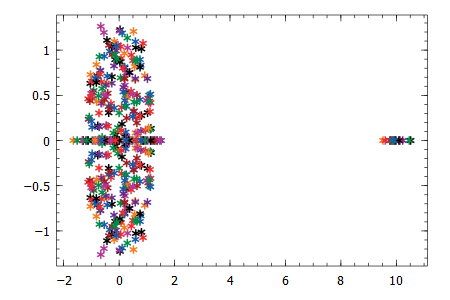

In [57]:
Winston.plot(E,"*")

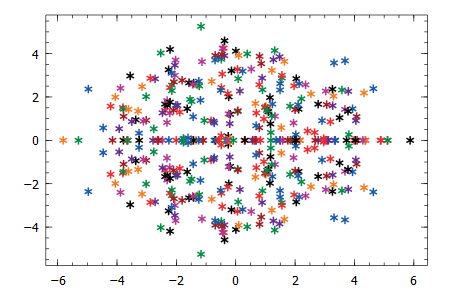

In [58]:
# Unsymmetric random normal distribution
E=Array{Any}(n,k)
for i=1:k
    A=randn(n,n)
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

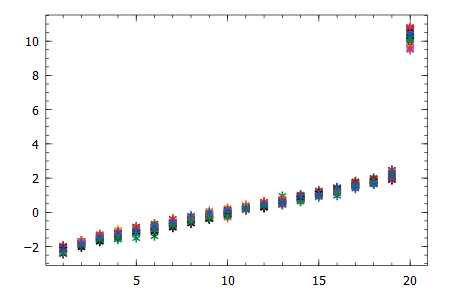

In [59]:
# Symmetric random uniform distribution
E=Array{Any}(n,k)
for i=1:k
    A=rand(n,n)
    A=triu(A)+triu(A,1)'
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

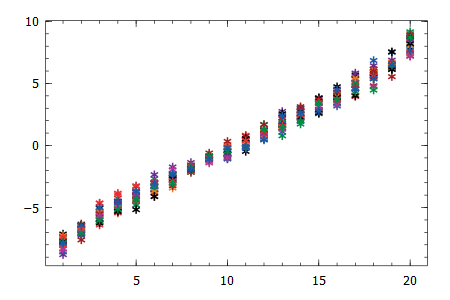

In [60]:
# Symmetric random normal distribution
E=Array{Any}(n,k)
for i=1:k
    A=randn(n,n)
    A=triu(A)+triu(A,1)'
    E[:,i]=eigvals(A)
end
# We need this for plot to work
E=map(eltype(E[1,1]),E)
Winston.plot(E,"*")

In [61]:
# Now the interactive partcxx
using Interact

Interact.Options{:SelectionSlider,Int64}(1: "input" = 20 Int64 , "k", 20, "20", 11, Interact.OptionDict(DataStructures.OrderedDict("10"=>10,"11"=>11,"12"=>12,"13"=>13,"14"=>14,"15"=>15,"16"=>16,"17"=>17,"18"=>18,"19"=>19…), Dict(30=>"30",16=>"16",11=>"11",21=>"21",26=>"26",25=>"25",10=>"10",29=>"29",19=>"19",17=>"17"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Int64}(3: "input-2" = 20 Int64 , "n", 20, "20", 11, Interact.OptionDict(DataStructures.OrderedDict("10"=>10,"11"=>11,"12"=>12,"13"=>13,"14"=>14,"15"=>15,"16"=>16,"17"=>17,"18"=>18,"19"=>19…), Dict(30=>"30",16=>"16",11=>"11",21=>"21",26=>"26",25=>"25",10=>"10",29=>"29",19=>"19",17=>"17"…)), Any[], Any[], true, "horizontal")

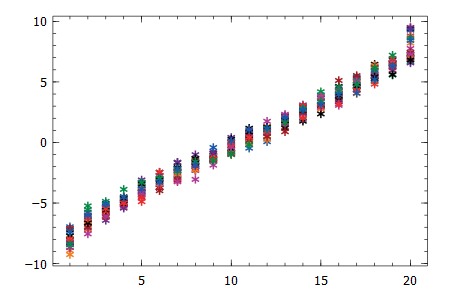

In [62]:
@manipulate for k=10:30, n=10:30
    E=Array{Any}(n,k)
    for i=1:k
        A=randn(n,n)
        A=triu(A)+triu(A,1)'
        E[:,i]=eigvals(A)
    end
    # We need this for plot to work
    E=map(eltype(E[1,1]),E)
    Winston.plot(E,"*")
end

_Mathematics is about spotting patterns_ (Alan Edelman)